In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt

In [17]:
x_train = tfd.Normal(loc=np.arange(8, dtype=np.float32),scale=1).sample(100)
e = tfd.Normal(loc=np.zeros(8, dtype=np.float32),scale=1).sample(100)

In [15]:
x_train.shape

TensorShape([100, 8])

In [18]:
y_train = x_train + e

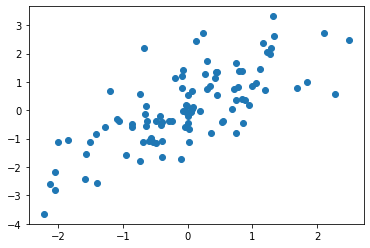

In [24]:
plt.scatter(x_train[:, 0], y_train[:, 0]);

### Modeling aleatoric uncertainty

Let's start by implementing a simple feedforward network with a probabilistic layer output. This probabilistic layer outputs is what allows us to model the aleatoric uncertainty (uncertainty or noise in the data). The network outputs a normal distribution object with a one dimensional event space where the mean and variance parameters are learned by the network. The network is trained by minimizing the negative log likelihood loss. The mean and variance of the output distribution are defined by the weights and biases present in the previous layers (before the output layer).

In [25]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(8,)),
    Dense(2),
    tfpl.IndependentNormal(1)
])

model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(x_train, y_train, epochs =200)

Epoch 1/200
4/4 [==============================] - 0s 2ms/step - loss: 22048490.4000
Epoch 2/200
4/4 [==============================] - 0s 1ms/step - loss: 8886116.0000
Epoch 3/200
4/4 [==============================] - 0s 1ms/step - loss: 4445791.4000
Epoch 4/200
4/4 [==============================] - 0s 904us/step - loss: 3421699.6500
Epoch 5/200
4/4 [==============================] - 0s 1ms/step - loss: 2393041.0000
Epoch 6/200
4/4 [==============================] - 0s 1ms/step - loss: 1741113.4500
Epoch 7/200
4/4 [==============================] - 0s 1ms/step - loss: 1405012.7750
Epoch 8/200
4/4 [==============================] - 0s 1ms/step - loss: 1095874.1000
Epoch 9/200
4/4 [==============================] - 0s 996us/step - loss: 1072872.7625
Epoch 10/200
4/4 [==============================] - 0s 939us/step - loss: 904769.7000
Epoch 11/200
4/4 [==============================] - 0s 1ms/step - loss: 715729.6875
Epoch 12/200
4/4 [==============================] - 0s 1ms/step - los

4/4 [==============================] - 0s 870us/step - loss: 19.0604
Epoch 101/200
4/4 [==============================] - 0s 1ms/step - loss: 19.0616
Epoch 102/200
4/4 [==============================] - 0s 1ms/step - loss: 19.0884
Epoch 103/200
4/4 [==============================] - 0s 1ms/step - loss: 19.0096
Epoch 104/200
4/4 [==============================] - 0s 1ms/step - loss: 19.0870
Epoch 105/200
4/4 [==============================] - 0s 1ms/step - loss: 19.1941
Epoch 106/200
4/4 [==============================] - 0s 1ms/step - loss: 19.0089
Epoch 107/200
4/4 [==============================] - 0s 967us/step - loss: 19.0320
Epoch 108/200
4/4 [==============================] - 0s 962us/step - loss: 18.9150
Epoch 109/200
4/4 [==============================] - 0s 900us/step - loss: 19.1153
Epoch 110/200
4/4 [==============================] - 0s 1ms/step - loss: 19.0221
Epoch 111/200
4/4 [==============================] - 0s 940us/step - loss: 19.0350
Epoch 112/200
4/4 [=============

4/4 [==============================] - 0s 1ms/step - loss: 18.9425


### Modeling epistemic uncertainty

After training this model we obtain point estimates for these weights and biases but in order to capture the epistemic uncertainty (uncertainty in the parameters) we want to learn the posterior distribution over these parameters.

#### Prior distribution

We start by defining the prior distribution over these paramters. This distribution represents our belief of what model parameters are likely before we've seen any data.

A standar assumption is that the prior distribution is a spherical gaussian. In other words it is an idependent normal distribution for each weight and bias, all with equal variance.

The function defined below will be used to define this prior distribution for a given dense layer. It takes the `kernel_size`, which is the number of parameters in the dense layer weights matrix and the `bias_size`, which is the number of bias parameters. It returns a callable object, in this case a lambda function. It takes an input tensor t and returns an independent normal distribution with mean zero and standard deviation 1.

This independent normal is the prior over the dense layer parameters. Notice that the mean is defined with a zero tensor of lenght $n$, where $n$ is the sum of the kernel size and bias size. The input tensor t will be input tensor to the dense layer that we will be defining this prior distribution for. Notice that t is not used in this distribution. In this example we are defining the prior distribution to be the same independent normal distribution regardless of the dense layer input. The prior also don't have any trainable variables , it won't change during the optimization procedure.

In [27]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
                                    reinterpreted_batch_ndims=1)

#### Posterior distribution

It receives the same paramters as the prior function. But this time we are returning a sequential model, which is in fact also a callable object. It receives a tensor as input and returns, once again, a distribution object. The `VariableLayer` is a simple layer type that returns a tensorflow variable when called regardless of the input. So the posterior distribution will also be independent of the tensor input to the dense layer. The distribution returned by the callable sequential model defines a distribution over the dense layer parameters. Notice that we are using the `convert_to_tensor_fn` to convert our output to a tensor by sampling from the output distribution. We need this tensor for our weights in order to run the forward pass of our model.

In [32]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n, convert_to_tensor_fn=tfd.Distribution.sample)
    ])

#### Model

The dense layers were replaced by the `DenseVariational` layers. These layers are similar to the regular dense layers, as you can define the number of units, input shape and activation function. But they require also the definition of a prior and posterior functions. The dense variational layer then adds the KL divergence loss in the optimization of the model. The KL divergence can be scaled according to the `kl_weight` keyword argument. Here we are setting it to be $1/N$, where $N$ is the size of the dataset. Normally, this is the setting we should use for this argument. Remeber that our objective is to maximize the ELBO:

$$\begin{aligned}
q &= q(w | \theta) \\
E_{W ~ q}[\log p(D|w)]-KL[q ||p] &= \sum_i E_{W ~ q}[\log p(D_i|w)]-KL[q ||p]
\end{aligned}$$

where $q$ is the posterior distribution over all the weights of our model. So you can think of $w$ being a vector over all model weights, which are now random variables and $\theta$ is a vector of parameters that parameterize this posterior. So these will be the means and variances of the independent normal distributions. The ELBO is given by two terms, the first is the expected log likelihood of the data, where the expectation is taken over the weights posterior. The second term is the KL divergence between the posterior and the prior, which you can think of of regularizing the posterior. Assuming i.i.d . data, the first term is equal to the sum of of the log likelihoods over all data points, so the index $i$ runs over the whole dataset. An important point to realize is that the first term is data dependent, while the second term is not. The KL divergence only depends on the posterior and prior distributions over the weights.

$$\begin{aligned}
\frac{N}{B} \sum_j E_{W ~ q}[\log p(D_j|w)]-KL[q ||p]
\end{aligned}$$

When we train the model we optimize the model using minibatches. That means the we only compute part of the that total sum over all datapoints. So we need to scale up the first term by a factor of $N/B$, where $N$ is the total dataset size and $B$ is the number of elements in the minibatch. With this adjustment, the first term is an unbiased estimate of the full data likelihood. The second term does not need any adjustment because it does not dependend on the datapoints at all. 

$$\begin{aligned}
\frac{1}{B} \sum_j E_{W ~ q}[\log p(D_j|w)]-\frac{1}{N}KL[q ||p]
\end{aligned}$$

Finally, we can compute the per sample loss or, in other words, the average expected log likelihood for each data point. This is what tensorflow computes when we pass in a minibatch of data. It will always average the loss for all elements in the minibatch. This is why we define the `kl_weight` to be $1/N$. As you can see by this derivation, it is the correct way to use to get an unbiased estimate of the true ELBO objective. 

In [33]:
N = x_train.shape[0]

In [34]:
model = Sequential([
    tfpl.DenseVariational(16, posterior, prior, kl_weight=1/N,
                       activation='relu', input_shape=(8,)),
    tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N),
    tfpl.IndependentNormal(1)
])

We are now ready to train our model. We are using the negative log likelihood for our loss. This loss is the first term of the ELBO that we've discussed before just with a change of sign. We are estimating the expected log likelihood with a single sample from the posterior on the forward pass as specified in the `convert_to_tensor_fn` in the posterior function definition. The KL divergence is added by each `DenseVariational` layer in the forward pass and so is included in the objective that we are optimizing. In the `DenseVariational` layer we can use the keyword `kl_use_exact` to define how it should be computed. Depending on the distributions used for the prior and posterior, it may be possible to analytically compute the KL divergence. If it is, then you can set the `kl_use_exact` to true. In the case that it is not possible to compute the KL divergence analitically, it will raise an error. With the `kl_use_exact` set to false (which is the default), the KL divergence loss will be estimated using the weights tensor obtained from the posterior distribution converted to a tensor function.

In [35]:
model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(x_train, y_train, epochs=200)

Epoch 1/200
4/4 [==============================] - 1s 909us/step - loss: 129037.2996
Epoch 2/200
4/4 [==============================] - 0s 1ms/step - loss: 205444293596268.2188
Epoch 3/200
4/4 [==============================] - 0s 943us/step - loss: 15060769.0000
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 128803494859201200.0000
Epoch 5/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 6/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 7/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 8/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 9/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 10/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 11/200
4/4 [==============================] - 0s 940us/step - loss: nan
Epoch 12/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 13/200
4/4 [==================

4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 108/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 109/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 110/200
4/4 [==============================] - 0s 2ms/step - loss: nan
Epoch 111/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 112/200
4/4 [==============================] - 0s 938us/step - loss: nan
Epoch 113/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 114/200
4/4 [==============================] - 0s 879us/step - loss: nan
Epoch 115/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 116/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 117/200
4/4 [==============================] - 0s 852us/step - loss: nan
Epoch 118/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 119/200
4/4 [==============================] - 0s 1ms/step - loss: nan
Epoch 1